# Tutorial 2 - More Realistic Example

This tutorial plots a ZIKV tree with 862 sequences, generated using `FastTree`. The tips of each tree in the `.nex` file are named only with the Genbank accession number, and there's a separate metadata csv containing a bunch more metadata associated with each each tip (sequence). 

Additional complications in this exercise:

* Retrieve metadata (country) from a `csv` file.
* Colour the tips which come from Singapore, USA or Australia
* Draw a legend

As an aside, this demonstrates two ways to set up your data: either have all relevant metadata in the fasta header, so that you'll only ever need to work with a single fasta file (my preferred method), or allocate some unique identifier for each sequence, and work with a fasta file which only has this unique identifier in the header, plus a csv with the rest of the metadata. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"]=42
mpl.rcParams['ps.fonttype']=42

import numpy as np
import pandas as pd
import time

from Bio import Phylo

import xio
import baltic3 as bt
import baltic3_utils as btu

In [2]:
# Load tree
tre = btu.austechia_read_tree("zikv_id_only_ft.nex", date_delim="|")

# Load metadata file
dm = pd.read_csv("zikv_m.csv")

Number of objects found in tree string: 1628

Tree height: 0.155210
Tree length: 2.051600

Numbers of objects in tree: 1628 (766 nodes and 862 leaves)

Highest tip date: 2017.7288


In [3]:
# Preview the first 5 rows of dm
# The unique identifier is in the column 'v_nm'
dm.head()

,v_nm,v_id,host,geoloc,cdate,seq
0,KU501216,103344,Human,Guatemala,2015-12-01,----------------------------------------------...
1,KX262887,103451,Human,Honduras,2016-01-06,-----gttgttgatctgtgtgaatcagactgcgacagttcgagttt...
2,MF073359,15098,Human,Brazil,2015-03-01,----agttgttgatctgtgtgaatcagactgcgacagttcgagttt...
3,MF073358,15261,Human,Brazil,2015-06-01,----agttgttgatctgtgtgaatcagactgcgacagttcgagttt...
4,MF073357,16288,Human,Brazil,2016-02-01,----agttgttgatctgtgtgaatcagactgcgacagttcgagttt...


We'll draw little circles at the tips from Singapore, USA or Australia, coloured according the dictionary `cdict` as defined in the cell above. We'll also draw a legend on our figure. Unfortunately, we'll have to do this legend manually, instead of using the inbuilt `fig.legend()` object (Doesn't matter if you don't know what that is). 

Our legend will be drawn as squares, where the heights, widths, exact coordinates and so on have to be defined exactly. The next cell shows the relevant `matplotlib` imports; remember that I usually define all imports at the very first cell. 

In [4]:
# =================================== PARAMS ===================================
# LAYOUT
fig_h = 12 # figure height
fig_w = 9 # figure width

# TREE PARAMS
branchWidth=0.5 # line thickness of branches
tip_shape_size=12 # tip shape size. 
x_offset= 0.00001
#It may be necessary to push the tree to the left to make room for the legend
#Otherwise, set this to an arbitrarily small number

# TEXT PARAMS
title_text = "ZIKV"
title_text_size = 30
title_x = 0.0001
title_y = tre.ySpan*0.9
tipname_x_offset = 0.01
tipname_fontsize = 12

# COLOUR DICTIONARY
cdict = {"Singapore":"indianred", "USA":"steelblue", "Australia":"green"}

# Matplotlib import required to draw rectangles (for the legend)
import matplotlib.patches as patches
rect_w = 0.01
rect_h = 35
rect_h_spacing = 0.2*rect_h # spacing between rectangles
rect_x0 = 0 # x-coordinate of the bottom left corner of the bottom-most legend rect
rect_y0 = 600 # y-coordinate of the bottom left corner of the bottom-most legend rect
fig_text_size = 20

Done in 6.17s


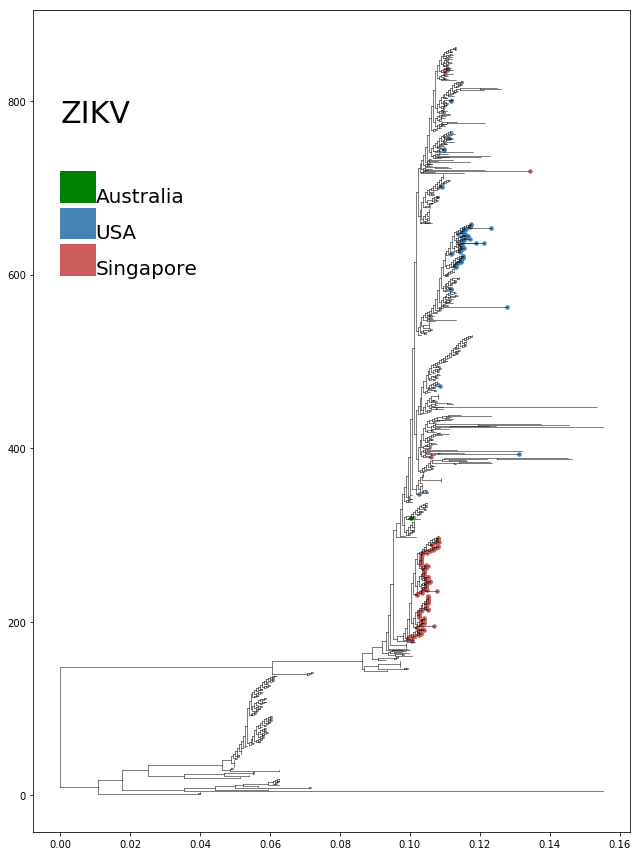

In [6]:
t0 = time.time()
fig,ax = plt.subplots(figsize=(fig_w, fig_h),facecolor='w')

for k in tre.Objects:
    c = 'k'
    x=k.height
    y=k.y

    xp = k.parent.height
    if x is None: # matplotlib won't plot Nones, like root
        x = x_offset
    if xp==None:
        xp = x + x_offset

    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        # Get the country from the metadata sheet
        my_id = k.name.split("|")[0]
        d_t = dm.loc[dm["v_nm"]==my_id]
        if len(d_t) != 1:
            print("WARNING: Problems retrieving country for ID %s!" % my_id)
        else:
            country = d_t["geoloc"].values[0]
            if country in list(cdict.keys()):
                ax.scatter(x, y, c=cdict[country], s=tip_shape_size)

    elif isinstance(k,bt.node) or k.branchType=='node':
        ax.plot([x,x],
                [k.children[-1].y,k.children[0].y],
                lw=branchWidth,
                color="k",ls='-',zorder=9)

    # Draw horizontal lines
    ax.plot([xp,x],[y,y],lw=branchWidth,color="k",ls='-',zorder=9)

# ==================== Figure Legend ====================
countries_ls = ["Singapore", "USA", "Australia"]
# Note that you can also use list(cdict.keys())
# but using a pre-defined list enforces iteration over that list in a particular order
# cdict.keys() kind of has a mind of its own, and does NOT always return a list in lexicographic order
for i in range(len(countries_ls)):
    # define coords, with a bit of maths
    x = rect_x0
    y = rect_y0 + (i*rect_h) + (i*rect_h_spacing)
    # create a 'Rectangle' patch
    rect = patches.Rectangle((x, y), # x,y coordinates, as a tuple
                             rect_w, # rectangle width
                             rect_h, # rectangle height
                             color=cdict[countries_ls[i]] # colour
                            )
    # add `rect` to the ax object
    ax.add_patch(rect)
    
    # Add figure text
    ax.text(x+(rect_w*1.01), y, countries_ls[i], fontsize=fig_text_size)


# title text
ax.text(title_x, title_y, title_text, fontsize=title_text_size)

# ==================== remove tick marks and borders ====================
#ax.set_yticks([])
#ax.set_xticks([])
#plt.axis('off')
plt.tight_layout()

# Save the figure to a pdf. 
#plt.savefig("my_zikv_tre.pdf", bbox_inches="tight")
print("Done in %.2fs" % (time.time() - t0))

plt.show()

# Bonus: Colouring (monophyletic) clades

Each `node` object has a `traits` attribute (i.e. `node.traits`), which is a dictionary of whatever you want.

In [7]:
inodes_ls = tre.nodes

# iterate over all nodes, node.traits dictionary with the associated country
# if all leaves of that node belong to the same country
# This code is actually pretty inefficient
my_tmrca = "*"
for nd in inodes_ls:
    leaves_ls_temp = nd.leaves
    leaves_ls_temp = [x.split("|")[0] for x in leaves_ls_temp]
    geoloc_ls = []
    for i in range(len(leaves_ls_temp)):
        geoloc = dm.loc[dm["v_nm"]==leaves_ls_temp[i]]["geoloc"].values[0]
        geoloc_ls.append(geoloc)
    if set(geoloc_ls) == {"Singapore"}:
        nd.traits["country"] = "Singapore"
    elif set(geoloc_ls) == {"USA"}:
        nd.traits["country"] = "USA"
    elif set(geoloc_ls) == {"Australia"}:
        nd.traits["country"] = "Australia"
    else:
        nd.traits["country"] = "*"


Done in 4.57s


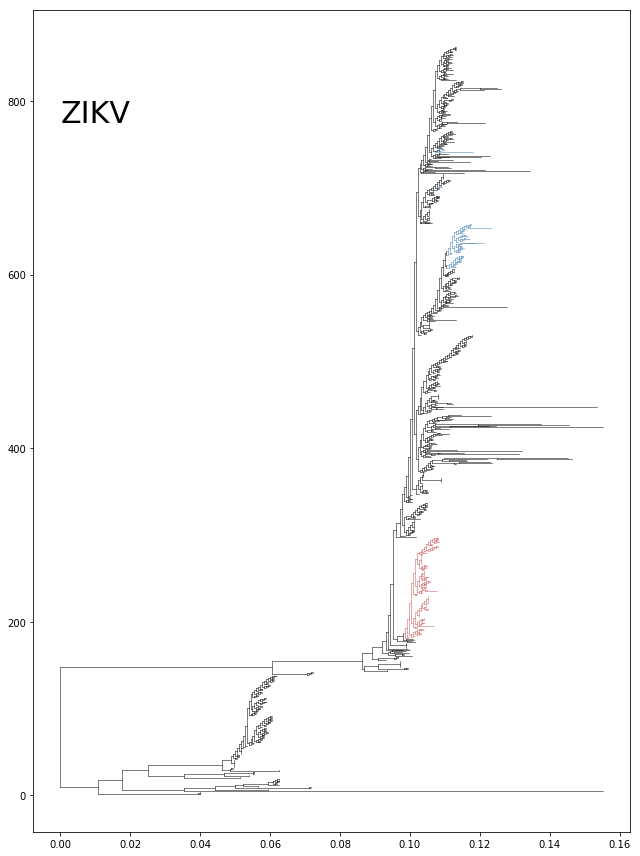

In [8]:
t0 = time.time()
fig,ax = plt.subplots(figsize=(fig_w, fig_h),facecolor='w')

for k in tre.Objects:
    c = 'k'
    x=k.height
    y=k.y

    xp = k.parent.height
    if x is None: # matplotlib won't plot Nones, like root
        x = x_offset
    if xp==None:
        xp = x + x_offset

    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        pass

    elif isinstance(k,bt.node) or k.branchType=='node':
        branch_c = "k"
        if k.traits['country'] in ["Singapore", "Australia", "USA"]:
            branch_c=cdict[k.traits['country']]

        ax.plot([x,x],
                [k.children[-1].y,k.children[0].y],
                lw=branchWidth,
                color=branch_c,ls='-',zorder=9)

    # Draw horizontal lines
    ax.plot([xp,x],[y,y],lw=branchWidth,color=branch_c,ls='-',zorder=9)

# title text
ax.text(title_x, title_y, title_text, fontsize=title_text_size)

# ==================== remove tick marks and borders ====================
#ax.set_yticks([])
#ax.set_xticks([])
#plt.axis('off')
plt.tight_layout()

# Save the figure to a pdf. 
#plt.savefig("my_zikv_tre.pdf", bbox_inches="tight")
print("Done in %.2fs" % (time.time() - t0))

plt.show()